# Import Dependencies

In [1]:
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
from torch.utils.data  import random_split
import torch.optim as optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import tqdm
import numpy as np
import random
# import timm

# import models
import torchvision.models as models

# Define parameters

In [2]:
# Hyperparameters
input_size = 256
batch_size = 32
lr = 0.00001
num_epochs = 5
workers = 0

In [3]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('Current device:', device)

Current device: cuda


# Load Dataset

In [4]:
train_path = r"D:\Users\andytsai\Desktop\programming\DeepLearning\EEE598\FinalProject\data\train_and_test\train"
test_path = r"D:\Users\andytsai\Desktop\programming\DeepLearning\EEE598\FinalProject\data\train_and_test\test"

Train on full dataset

In [5]:
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
     transforms.RandomHorizontalFlip(p=0.5),  # Flip the image horizontally with a 50% chance
    transforms.RandomVerticalFlip(p=0.5),    # Flip the image vertically with a 50% chance
    transforms.RandomRotation(degrees=45),   # Rotate the image by up to 45 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Print out the number of classes
num_classes = len(train_dataset.classes)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

In [6]:
print(len(test_dataset))

50161


Train on subset

In [7]:
# # Load the dataset
# transform = transforms.Compose([
#     transforms.Resize((input_size, input_size)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# train_dataset = datasets.ImageFolder(train_path, transform=transform)
# test_dataset = datasets.ImageFolder(test_path, transform=transform)

# # Create a subset of 1000 classes
# subset_class = 1000

# # Print out the number of classes
# num_classes = subset_class

# # Get indices of selected classes
# selected_class_indices = train_dataset.classes[:num_classes]

# # Filter training dataset
# train_indices = [i for i, (_, label) in enumerate(train_dataset) if label in selected_class_indices]
# train_subset = Subset(train_dataset, train_indices)

# # Filter testing dataset
# test_indices = [i for i, (_, label) in enumerate(test_dataset) if label in selected_class_indices]
# test_subset = Subset(test_dataset, test_indices)

# # Apply transformations to datasets
# train_subset.dataset.transform = transform
# test_subset.dataset.transform = transform

# # Create DataLoader for batch
# train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_subset, batch_size=batch_size, shuffle=False)

Show dataset

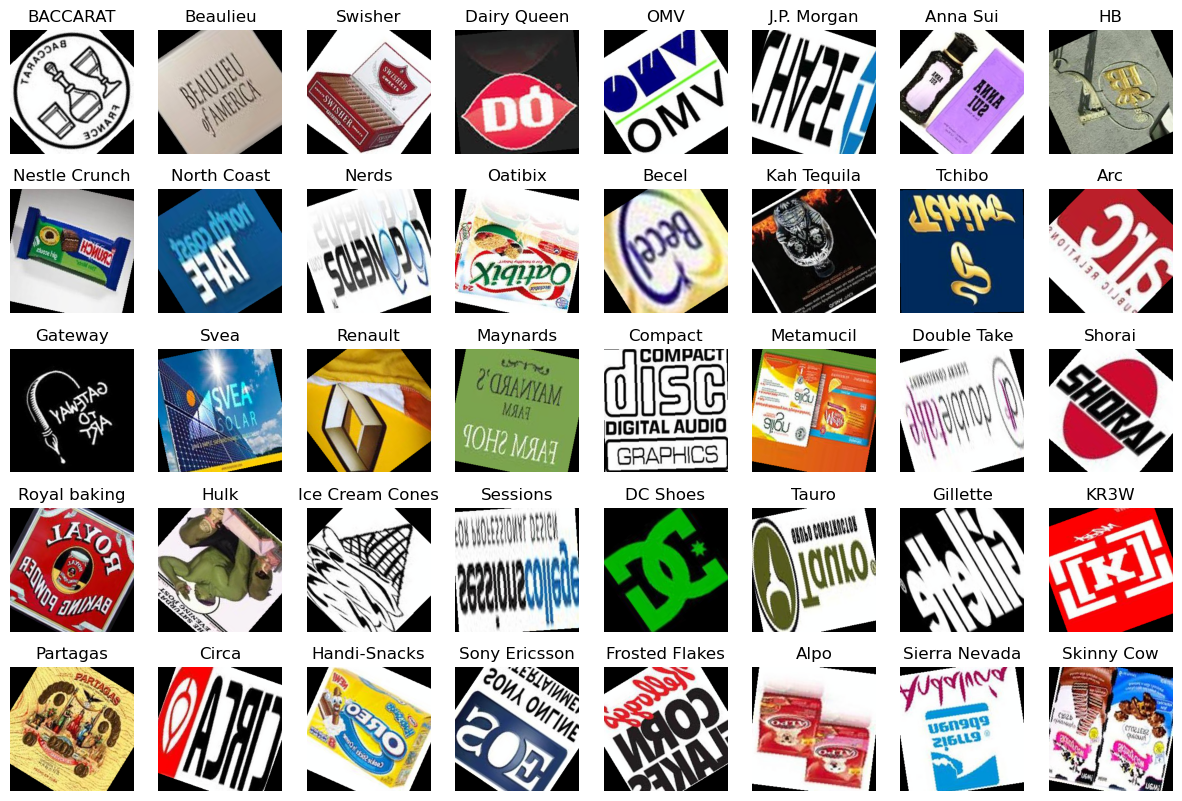

In [8]:
# Assuming `test_dataset` is defined, with .classes attribute
num_img = 40
random_labels = random.sample(range(len(test_dataset)), num_img)

# Normalization parameters
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

row = 5
col = num_img//row

# Create a grid of subplots: 2 rows, 4 columns (for 8 images)
fig, axes = plt.subplots(row, col, figsize=(15, 10))  # Adjust columns to match num_img

for i, ax in enumerate(axes.flat):  # Use `axes.flat` to loop over all axes
    if i < num_img:
        # Get the image and label
        img, label = test_dataset[random_labels[i]]
        label_name = test_dataset.classes[label]
        
        # Unnormalize the image
        img = img.cpu().permute(1, 2, 0).numpy()  # Convert to HWC for display
        img = img * std + mean  # Unnormalize the image
        img = img.clip(0, 1)  # Clip pixel values to [0, 1]
        
        # Display the image
        ax.imshow(img)
        ax.set_title(label_name)  # Set the title to the label name
        ax.axis('off')  # Turn off the axis
    else:
        ax.axis('off')  # If there are unused subplots, turn them off

# plt.tight_layout()  # Adjust spacing
plt.show()


# Define model, optimizer, loss function, loss decay

In [9]:
# Define model
model = models.efficientnet_b0(pretrained=True)
input_features = model.classifier[1].in_features  # Dynamically get the input size
model.classifier[1] = nn.Linear(in_features=input_features, out_features=num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# # Define the scheduler
# scheduler = StepLR(optimizer, step_size=5, gamma=0.9)  # Decays lr by 10% every 2 epochs

f:\Users\andytsai\anaconda3\envs\DP\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\Users\andytsai\anaconda3\envs\DP\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training loop

Define training, testing function

In [10]:
# Define training and testing function
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = []
    total_img = 0
    correct = 0
    
    # Training loop
    for imgs, labels in tqdm.tqdm(train_loader, desc='Training', leave=False):


        # Move to device
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass
        outputs = model(imgs)

        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Loss
        running_loss.append(loss.item())
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total_img += labels.size(0)
    
    avg_loss = sum(running_loss) / len(train_loader)
    accuracy = 100 * correct / total_img

    return avg_loss, accuracy, running_loss


def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total_img = 0
    

    with torch.no_grad():
        for imgs, labels in tqdm.tqdm(test_loader, desc='Testing', leave=False):
            # Move to device
            imgs, labels = imgs.to(device), labels.to(device)


            # Forward pass
            outputs = model(imgs)

            loss = criterion(outputs, labels)

            # Loss
            running_loss = loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total_img += labels.size(0)
            
    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total_img

    # return avg_loss, accuracy
    return avg_loss, accuracy

Use pretrained model

In [11]:
# # test_loss, test_accuracy = test_model(model, test_loader, criterion, device)
# test_loss, correct, total_img= test_model(model, test_loader, criterion, device)
# # print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.3f}%\n")
# print(f"Testing Loss: {test_loss:.4f}, Correct: {correct}, Total image: {total_img}\n")

Implement training

In [12]:
# Record the best accuracy
best_accuracy = 0
best_model_epoch = 0
training_loss = []

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')

    # Train the model
    train_loss, train_accuracy, running_loss = train_model(model, train_loader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.3f}%")
    training_loss.extend(running_loss)

    # Testing the model
    test_loss, test_accuracy = test_model(model, test_loader, criterion, device)
    print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.3f}%\n")
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_epoch = epoch+1
        
        save_path = r"D:\Users\andytsai\Desktop\programming\DeepLearning\EEE598\FinalProject\TrainedModels\EfficientNet.pth"

        # Save the trained model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'train_loss': train_loss,
        }, save_path)

    # Step the scheduler at the end of each epoch
    # scheduler.step()

    # Clean cuda cache
    torch.cuda.empty_cache()

Epoch: 1/5


KeyboardInterrupt: 

# Result

Best testing accuracy over 5 epochs is: 58.553% in 5 epoch.


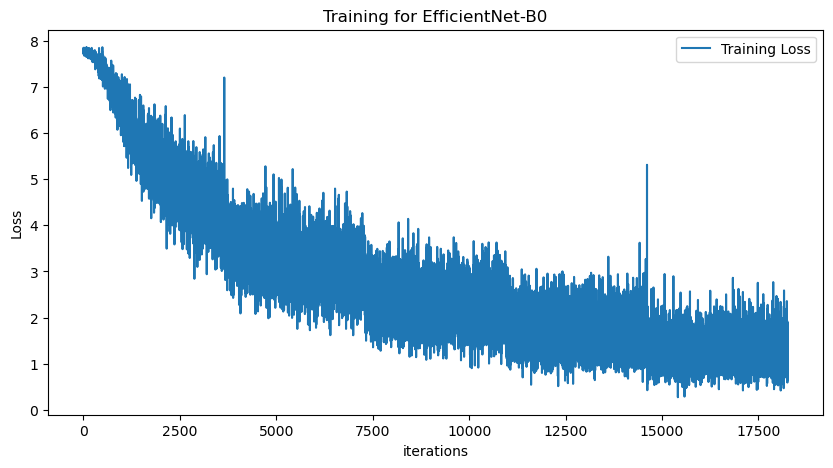

In [ ]:
print(f"Best testing accuracy over {num_epochs} epochs is: {best_accuracy:.3f}% in {best_model_epoch} epoch.")
save_path = r'D:\Users\andytsai\Desktop\programming\DeepLearning\EEE598\FinalProject\loss_img\EfficientNet.png'
x_label = list(range(len(training_loss)))
plt.figure(figsize=(10,5))
plt.title("Training for EfficientNet-B0")
plt.plot(x_label, training_loss, label="Training Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(save_path,  bbox_inches='tight')
plt.show()